In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly import express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go # Plotly graph objects!
import statsmodels.formula.api as sm

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold, TimeSeriesSplit
#from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_text

# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor

# statsmodels: pretty and good to use, great for interpretable ML
from statsmodels.formula.api import ols, logit
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from IPython.display import Image

# !pip install hide_code
# !jupyter nbextension install --py --user hide_code
# !jupyter nbextension enable --py --user hide_code
# !jupyter serverextension enable --py --user hide_code

In [170]:
import os
os.getcwd()
os.chdir('/Users/az/data_projects/ca_pfl/FMLA')

### Import Datasets and Copy

In [173]:
capfl_o = pd.read_csv('ca_edd_data_05_2024.csv')
capfl = capfl_o.copy(deep=True)

income_o = pd.read_csv('med_house_income_ca_2023.csv')
income = income_o.copy(deep=True)

# births_o = pd.read_csv('ca_births_clean_3.csv')
# births = births_o.copy(deep=True)

# labor_o = pd.read_csv('Labor_Force_Participation_Rate__US_and_California_2.csv')
# labor = labor_o.copy(deep=True)

# states_o = pd.read_csv('states_pfl_new.csv')
# states = states_o.copy(deep=True)

# survey = pd.io.stata.read_stata('WHD_FMLA2018EmployeePUF_StataDataSet_Aug2020.dta')
# survey.to_csv('fmla_dataset.csv')

In [111]:
def year_to_month(df, time_index):
    df.set_index('date', inplace=True)
    df = df.resample('M').ffill()
    df = df.reindex(time_index).ffill()
    df = df.reset_index()
    df.rename(columns={'index': 'date'}, inplace=True)
    df.set_index('date', inplace=True)

    return df

### Median Income Data

In [112]:
income.head()

,DATE,MEHOINUSCAA646N
0,2005-01-01,51760
1,2006-01-01,55320
2,2007-01-01,55730
3,2008-01-01,57010
4,2009-01-01,56130


In [113]:
income.tail()

,DATE,MEHOINUSCAA646N
14,2019-01-01,78100
15,2020-01-01,77650
16,2021-01-01,81580
17,2022-01-01,85300
18,2023-01-01,89870


In [114]:
income.rename(columns={
            'MEHOINUSCAA646N': 'median_income',
            'DATE': 'date'}, 
            inplace=True)
income['median_income_logged'] = np.log10(income['median_income'])

income['median_income_weekly'] = income['median_income'] / 52
income['median_income_weekly_logged'] = np.log10(income['median_income_weekly'])

income['median_55%'] = income['median_income_weekly'] * 0.55

income['date'] = pd.to_datetime(income['date'])

income

,date,median_income,median_income_logged,median_income_weekly,median_income_weekly_logged,median_55%
0,2005-01-01,51760,4.713994,995.384615,2.997991,547.461538
1,2006-01-01,55320,4.742882,1063.846154,3.026879,585.115385
2,2007-01-01,55730,4.746089,1071.730769,3.030086,589.451923
3,2008-01-01,57010,4.755951,1096.346154,3.039948,602.990385
4,2009-01-01,56130,4.749195,1079.423077,3.033192,593.682692
5,2010-01-01,54280,4.734640,1043.846154,3.018636,574.115385
6,2011-01-01,53370,4.727297,1026.346154,3.011294,564.490385
7,2012-01-01,57020,4.756027,1096.538462,3.040024,603.096154
8,2013-01-01,60790,4.783832,1169.038462,3.067829,642.971154
9,2014-01-01,60490,4.781684,1163.269231,3.065680,639.798077


In [115]:
t_index = pd.DatetimeIndex(pd.date_range(start='2005-01-01', end='2023-12-31', freq='M'))

income = year_to_month(income, t_index)

In [116]:
income.tail(15)

,median_income,median_income_logged,median_income_weekly,median_income_weekly_logged,median_55%
date,,,,,
2022-10-31,85300.0,4.930949,1640.384615,3.214946,902.211538
2022-11-30,85300.0,4.930949,1640.384615,3.214946,902.211538
2022-12-31,85300.0,4.930949,1640.384615,3.214946,902.211538
2023-01-31,89870.0,4.953615,1728.269231,3.237611,950.548077
2023-02-28,89870.0,4.953615,1728.269231,3.237611,950.548077
2023-03-31,89870.0,4.953615,1728.269231,3.237611,950.548077
2023-04-30,89870.0,4.953615,1728.269231,3.237611,950.548077
2023-05-31,89870.0,4.953615,1728.269231,3.237611,950.548077
2023-06-30,89870.0,4.953615,1728.269231,3.237611,950.548077


### Weekly Benefit Maximum Data

In [117]:
mwba = {
    'year': [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'max_amt': [728, 840, 882, 917, 959, 987, 987, 1011, 1067, 1075, 1104, 1129, 1173, 1216, 1252, 1300, 1357, 1540, 1620],
}

mwba = pd.DataFrame(mwba)

mwba['max_amt_change'] = mwba['max_amt'].pct_change() * 100
mwba['date'] = pd.to_datetime(mwba['year'], format='%Y')

In [118]:
mwba

,year,max_amt,max_amt_change,date
0,2005,728,NaN,2005-01-01
1,2006,840,15.384615,2006-01-01
2,2007,882,5.000000,2007-01-01
3,2008,917,3.968254,2008-01-01
4,2009,959,4.580153,2009-01-01
5,2010,987,2.919708,2010-01-01
6,2011,987,0.000000,2011-01-01
7,2012,1011,2.431611,2012-01-01
8,2013,1067,5.539070,2013-01-01
9,2014,1075,0.749766,2014-01-01


In [119]:
t_index = pd.DatetimeIndex(pd.date_range(start='2005-01-01', end='2023-12-31', freq='M'))

mwba = year_to_month(mwba, t_index)
mwba.tail(15)

,year,max_amt,max_amt_change
date,,,
2022-10-31,2022.0,1540.0,13.485630
2022-11-30,2022.0,1540.0,13.485630
2022-12-31,2022.0,1540.0,13.485630
2023-01-31,2023.0,1620.0,5.194805
2023-02-28,2023.0,1620.0,5.194805
2023-03-31,2023.0,1620.0,5.194805
2023-04-30,2023.0,1620.0,5.194805
2023-05-31,2023.0,1620.0,5.194805
2023-06-30,2023.0,1620.0,5.194805


### Maximum Number of Weeks for Benefit Data

In [120]:
max_weeks = {
    'year': [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'max_num_weeks': [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8],
}

max_weeks = pd.DataFrame(max_weeks)
max_weeks['date'] = pd.to_datetime(max_weeks['year'], format='%Y')
max_weeks.tail()

,year,max_num_weeks,date
14,2019,6,2019-01-01
15,2020,8,2020-01-01
16,2021,8,2021-01-01
17,2022,8,2022-01-01
18,2023,8,2023-01-01


In [121]:
t_index = pd.DatetimeIndex(pd.date_range(start='2005-01-01', end='2023-12-31', freq='M'))

max_weeks = year_to_month(max_weeks, t_index)
max_weeks.tail(15)

,year,max_num_weeks
date,,
2022-10-31,2022.0,8.0
2022-11-30,2022.0,8.0
2022-12-31,2022.0,8.0
2023-01-31,2023.0,8.0
2023-02-28,2023.0,8.0
2023-03-31,2023.0,8.0
2023-04-30,2023.0,8.0
2023-05-31,2023.0,8.0
2023-06-30,2023.0,8.0


# Births (not updated with 2022-24 data)

In [14]:
births.head()

,year,month_num,month,geography_type,strata,strata_name,count
0,2005,1,January,Occurrence,Total Population,Total Population,44310
1,2005,2,February,Occurrence,Total Population,Total Population,40833
2,2005,3,March,Occurrence,Total Population,Total Population,46084
3,2005,4,April,Occurrence,Total Population,Total Population,43647
4,2005,5,May,Occurrence,Total Population,Total Population,44865


In [15]:
births['date'] = births['year'].astype(str) + '-' + births['month_num'].astype(str)
births['date'] = pd.to_datetime(births['date'],format='%Y-%m')
births.head()

,year,month_num,month,geography_type,strata,strata_name,count,date
0,2005,1,January,Occurrence,Total Population,Total Population,44310,2005-01-01
1,2005,2,February,Occurrence,Total Population,Total Population,40833,2005-02-01
2,2005,3,March,Occurrence,Total Population,Total Population,46084,2005-03-01
3,2005,4,April,Occurrence,Total Population,Total Population,43647,2005-04-01
4,2005,5,May,Occurrence,Total Population,Total Population,44865,2005-05-01


In [16]:
births = births.set_index('date')
births.index = births.index + pd.offsets.MonthEnd(0)

births.head()

,year,month_num,month,geography_type,strata,strata_name,count
date,,,,,,,
2005-01-31,2005,1,January,Occurrence,Total Population,Total Population,44310
2005-02-28,2005,2,February,Occurrence,Total Population,Total Population,40833
2005-03-31,2005,3,March,Occurrence,Total Population,Total Population,46084
2005-04-30,2005,4,April,Occurrence,Total Population,Total Population,43647
2005-05-31,2005,5,May,Occurrence,Total Population,Total Population,44865


# CA Paid Family Leave Data

In [122]:
capfl

,Date,Month,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,Average Duration,Total Benefits Authorized
0,5/31/2024,May,2024,"25,079","20,449","4,624","22,851","19,561","3,613",934.67,"168,946",7.27,"$157,908,442.00"
1,4/30/2024,April,2024,"26,996","22,913","4,074","24,597","21,653","3,237",927.11,"180,891",7.17,"$167,706,275.00"
2,3/31/2024,March,2024,"24,675","20,433","4,238","23,203","19,834","3,531",924.10,"166,119",7.12,"$153,511,365.00"
3,2/29/2024,February,2024,"26,847","22,735","4,100","24,430","21,488","3,129",931.54,"175,395",7.14,"$163,387,745.00"
4,1/30/2024,January,2024,"30,181","26,107","4,063","27,184","24,256","3,087",930.58,"207,504",7.15,"$193,099,365.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,11/30/2004,November,2004,"11,571","10,037","1,534","10,922","9,722","1,265",406.70,"61,517",NaN,"$25,019,053.00"
235,10/31/2004,October,2004,"12,890","11,126","1,764","11,581","10,157","1,489",406.39,"60,366",NaN,"$24,531,891.00"
236,9/30/2004,September,2004,"12,555","10,904","1,651","11,898","10,506","1,405",409.56,"60,322",NaN,"$24,705,246.00"
237,8/31/2004,August,2004,"18,885","16,503","2,382","16,214","14,771","1,443",408.27,"78,326",NaN,"$31,978,400.00"


In [123]:
capfl.tail()

,Date,Month,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,Average Duration,Total Benefits Authorized
234,11/30/2004,November,2004,"11,571","10,037","1,534","10,922","9,722","1,265",406.70,"61,517",NaN,"$25,019,053.00"
235,10/31/2004,October,2004,"12,890","11,126","1,764","11,581","10,157","1,489",406.39,"60,366",NaN,"$24,531,891.00"
236,9/30/2004,September,2004,"12,555","10,904","1,651","11,898","10,506","1,405",409.56,"60,322",NaN,"$24,705,246.00"
237,8/31/2004,August,2004,"18,885","16,503","2,382","16,214","14,771","1,443",408.27,"78,326",NaN,"$31,978,400.00"
238,7/31/2004,July,2004,"5,296","2,916","2,380","3,621","2,763",858,388.95,"13,102",NaN,"$5,095,960.00"


In [124]:
for column in capfl.columns:
    if capfl[column].dtype == 'object':
        capfl[column] = capfl[column].str.replace(",", "")
    elif capfl[column].dtype in ['int64', 'float64']: 
        capfl[column] = capfl[column].astype(str).str.replace(",", "").astype(float)

In [126]:
capfl = capfl.rename(columns= {'Date': 'old_date'})
capfl['date'] = pd.to_datetime(capfl['old_date'])
capfl.date.dtype

dtype('<M8[ns]')

In [127]:
capfl.dtypes

old_date                                            object
Month                                               object
Year                                               float64
Total PFL First Claims Filed                        object
Bonding Claims Filed                                object
Care Claims Filed                                   object
Total PFL First Claims Paid                         object
Bonding Claims Paid                                 object
Care Claims Paid                                    object
PFL Average Weekly Benefit Amount (AWBA)           float64
Weeks Compensated                                   object
Average Duration                                   float64
Total Benefits Authorized                           object
date                                        datetime64[ns]
dtype: object

In [128]:
new_dtypes_int = {}
int_dtypes = ["Total PFL First Claims Filed", "Bonding Claims Filed", "Care Claims Filed", "Total PFL First Claims Paid", "Bonding Claims Paid","Care Claims Paid", "Weeks Compensated", "Weeks Compensated"]

for item in int_dtypes:
    new_dtypes_int.update({item: "int64"}) 

capfl = capfl.astype(new_dtypes_int)
# capfl.dtypes

In [129]:
capfl['Total Benefits Authorized'] = capfl['Total Benefits Authorized'].str.replace("$","").astype('float64')

In [130]:
new_dtypes_obj = {}

for column in capfl.columns:    
    if capfl[column].dtype == 'object':
        new_dtypes_obj.update({column: "category"}) 

capfl = capfl.astype(new_dtypes_obj)
capfl.dtypes

old_date                                          category
Month                                             category
Year                                               float64
Total PFL First Claims Filed                         int64
Bonding Claims Filed                                 int64
Care Claims Filed                                    int64
Total PFL First Claims Paid                          int64
Bonding Claims Paid                                  int64
Care Claims Paid                                     int64
PFL Average Weekly Benefit Amount (AWBA)           float64
Weeks Compensated                                    int64
Average Duration                                   float64
Total Benefits Authorized                          float64
date                                        datetime64[ns]
dtype: object

In [131]:
capfl['Month'] = capfl.Month.cat.reorder_categories(
    new_categories = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
                     'October', 'November', 'December'],
    ordered = True)

In [132]:
capfl.columns

Index(['old_date', 'Month', 'Year', 'Total PFL First Claims Filed',
       'Bonding Claims Filed', 'Care Claims Filed',
       'Total PFL First Claims Paid', 'Bonding Claims Paid',
       'Care Claims Paid', 'PFL Average Weekly Benefit Amount (AWBA)',
       'Weeks Compensated', 'Average Duration', 'Total Benefits Authorized',
       'date'],
      dtype='object')

In [133]:
capfl.head()

,old_date,Month,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,Average Duration,Total Benefits Authorized,date
0,5/31/2024,May,2024.0,25079,20449,4624,22851,19561,3613,934.67,168946,7.27,157908442.0,2024-05-31
1,4/30/2024,April,2024.0,26996,22913,4074,24597,21653,3237,927.11,180891,7.17,167706275.0,2024-04-30
2,3/31/2024,March,2024.0,24675,20433,4238,23203,19834,3531,924.10,166119,7.12,153511365.0,2024-03-31
3,2/29/2024,February,2024.0,26847,22735,4100,24430,21488,3129,931.54,175395,7.14,163387745.0,2024-02-29
4,1/30/2024,January,2024.0,30181,26107,4063,27184,24256,3087,930.58,207504,7.15,193099365.0,2024-01-30


In [134]:
# Logging variables
capfl['Total Benefits Authorized Logged'] = np.log10(capfl['Total Benefits Authorized'])
# capfl['log_bond_file'] = np.log10(capfl['bond_file'])

In [135]:
# 2004 and 2024 removed from CA PFL dataset (not enough data for 2004 or 2024)
capfl_sub = capfl[~capfl['Year'].isin([2004, 2024])].copy()

In [136]:
# capfl_clean['missing_claims_tot'] = capfl_clean['tot_pfl_filed'] - capfl_clean['tot_pfl_paid']
# capfl_clean.head()

In [137]:
capfl_sub.head()

,old_date,Month,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,Average Duration,Total Benefits Authorized,date,Total Benefits Authorized Logged
5,12/31/2023,December,2023.0,26654,22924,3724,24415,21544,2989,918.15,177664,7.12,163121999.0,2023-12-31,8.212513
6,11/30/2023,November,2023.0,23475,20324,3144,21757,19008,2747,916.68,167346,7.15,153402907.0,2023-11-30,8.185834
7,10/31/2023,October,2023.0,27190,22479,4708,24959,21297,3657,914.54,181717,7.15,166187641.0,2023-10-31,8.220599
8,9/30/2023,September,2023.0,22908,19104,3794,22628,19126,3499,921.52,165971,7.15,152945659.0,2023-09-30,8.184537
9,8/31/2023,August,2023.0,30123,24549,5566,27657,23421,4232,924.50,187923,7.13,173735861.0,2023-08-31,8.239889


In [138]:
# Checking for NAs
capfl_sub.isna().sum()

old_date                                    0
Month                                       0
Year                                        0
Total PFL First Claims Filed                0
Bonding Claims Filed                        0
Care Claims Filed                           0
Total PFL First Claims Paid                 0
Bonding Claims Paid                         0
Care Claims Paid                            0
PFL Average Weekly Benefit Amount (AWBA)    0
Weeks Compensated                           0
Average Duration                            5
Total Benefits Authorized                   0
date                                        0
Total Benefits Authorized Logged            0
dtype: int64

In [139]:
capfl_sub[capfl_sub['Average Duration'].isna()]

,old_date,Month,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,Average Duration,Total Benefits Authorized,date,Total Benefits Authorized Logged
228,5/31/2005,May,2005.0,12007,10531,1476,11545,10193,1352,421.92,62298,NaN,26284761.0,2005-05-31,7.419704
229,4/30/2005,April,2005.0,15534,13444,2088,14361,12758,1603,413.11,70288,NaN,29036867.0,2005-04-30,7.462950
230,3/31/2005,March,2005.0,11421,9868,1553,10888,9549,1339,410.89,61203,NaN,25147702.0,2005-03-31,7.400498
231,2/28/2005,February,2005.0,10052,8868,1184,9730,8707,1023,408.93,57004,NaN,23310658.0,2005-02-28,7.367555
232,1/31/2005,January,2005.0,13029,11754,1275,12719,11473,1246,401.12,66725,NaN,26764715.0,2005-01-31,7.427563


In [140]:
# Interpolating missing data for average duration
capfl_sub['Average Duration'] = capfl_sub['Average Duration'].interpolate(method = 'linear')

In [141]:
# Checking that interpolation worked
capfl_sub.isna().sum()

old_date                                    0
Month                                       0
Year                                        0
Total PFL First Claims Filed                0
Bonding Claims Filed                        0
Care Claims Filed                           0
Total PFL First Claims Paid                 0
Bonding Claims Paid                         0
Care Claims Paid                            0
PFL Average Weekly Benefit Amount (AWBA)    0
Weeks Compensated                           0
Average Duration                            0
Total Benefits Authorized                   0
date                                        0
Total Benefits Authorized Logged            0
dtype: int64

In [142]:
capfl_sub.set_index(['date'], drop = True, inplace = True)

In [143]:
capfl_sub = capfl_sub.sort_values('date')

In [144]:
capfl_sub.head()

,old_date,Month,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,Average Duration,Total Benefits Authorized,Total Benefits Authorized Logged
date,,,,,,,,,,,,,,
2005-01-31,1/31/2005,January,2005.0,13029,11754,1275,12719,11473,1246,401.12,66725,5.23,26764715.0,7.427563
2005-02-28,2/28/2005,February,2005.0,10052,8868,1184,9730,8707,1023,408.93,57004,5.23,23310658.0,7.367555
2005-03-31,3/31/2005,March,2005.0,11421,9868,1553,10888,9549,1339,410.89,61203,5.23,25147702.0,7.400498
2005-04-30,4/30/2005,April,2005.0,15534,13444,2088,14361,12758,1603,413.11,70288,5.23,29036867.0,7.462950
2005-05-31,5/31/2005,May,2005.0,12007,10531,1476,11545,10193,1352,421.92,62298,5.23,26284761.0,7.419704


In [145]:
capfl_sub.tail()

,old_date,Month,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,Average Duration,Total Benefits Authorized,Total Benefits Authorized Logged
date,,,,,,,,,,,,,,
2023-08-31,8/31/2023,August,2023.0,30123,24549,5566,27657,23421,4232,924.50,187923,7.13,173735861.0,8.239889
2023-09-30,9/30/2023,September,2023.0,22908,19104,3794,22628,19126,3499,921.52,165971,7.15,152945659.0,8.184537
2023-10-31,10/31/2023,October,2023.0,27190,22479,4708,24959,21297,3657,914.54,181717,7.15,166187641.0,8.220599
2023-11-30,11/30/2023,November,2023.0,23475,20324,3144,21757,19008,2747,916.68,167346,7.15,153402907.0,8.185834
2023-12-31,12/31/2023,December,2023.0,26654,22924,3724,24415,21544,2989,918.15,177664,7.12,163121999.0,8.212513


In [146]:
monthly_counts = capfl_sub['Year'].resample('M').count()
monthly_counts.index = monthly_counts.index.to_period('M').to_timestamp()

In [147]:
monthly_counts.isna().value_counts()

Year
False    228
Name: count, dtype: int64

# Merging Datasets

In [148]:
capfl_merged = pd.merge(capfl_sub, income, 'outer', left_index=True, right_index=True)

In [149]:
capfl_merged.head()

,old_date,Month,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,Average Duration,Total Benefits Authorized,Total Benefits Authorized Logged,median_income,median_income_logged,median_income_weekly,median_income_weekly_logged,median_55%
date,,,,,,,,,,,,,,,,,,,
2005-01-31,1/31/2005,January,2005.0,13029,11754,1275,12719,11473,1246,401.12,66725,5.23,26764715.0,7.427563,51760.0,4.713994,995.384615,2.997991,547.461538
2005-02-28,2/28/2005,February,2005.0,10052,8868,1184,9730,8707,1023,408.93,57004,5.23,23310658.0,7.367555,51760.0,4.713994,995.384615,2.997991,547.461538
2005-03-31,3/31/2005,March,2005.0,11421,9868,1553,10888,9549,1339,410.89,61203,5.23,25147702.0,7.400498,51760.0,4.713994,995.384615,2.997991,547.461538
2005-04-30,4/30/2005,April,2005.0,15534,13444,2088,14361,12758,1603,413.11,70288,5.23,29036867.0,7.462950,51760.0,4.713994,995.384615,2.997991,547.461538
2005-05-31,5/31/2005,May,2005.0,12007,10531,1476,11545,10193,1352,421.92,62298,5.23,26284761.0,7.419704,51760.0,4.713994,995.384615,2.997991,547.461538


In [150]:
capfl_merged = pd.merge(capfl_merged, mwba, 'outer', left_index=True, right_index=True)

In [151]:
capfl_merged.tail()

,old_date,Month,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),...,Total Benefits Authorized,Total Benefits Authorized Logged,median_income,median_income_logged,median_income_weekly,median_income_weekly_logged,median_55%,year,max_amt,max_amt_change
date,,,,,,,,,,,,,,,,,,,,,
2023-08-31,8/31/2023,August,2023.0,30123,24549,5566,27657,23421,4232,924.50,...,173735861.0,8.239889,89870.0,4.953615,1728.269231,3.237611,950.548077,2023.0,1620.0,5.194805
2023-09-30,9/30/2023,September,2023.0,22908,19104,3794,22628,19126,3499,921.52,...,152945659.0,8.184537,89870.0,4.953615,1728.269231,3.237611,950.548077,2023.0,1620.0,5.194805
2023-10-31,10/31/2023,October,2023.0,27190,22479,4708,24959,21297,3657,914.54,...,166187641.0,8.220599,89870.0,4.953615,1728.269231,3.237611,950.548077,2023.0,1620.0,5.194805
2023-11-30,11/30/2023,November,2023.0,23475,20324,3144,21757,19008,2747,916.68,...,153402907.0,8.185834,89870.0,4.953615,1728.269231,3.237611,950.548077,2023.0,1620.0,5.194805
2023-12-31,12/31/2023,December,2023.0,26654,22924,3724,24415,21544,2989,918.15,...,163121999.0,8.212513,89870.0,4.953615,1728.269231,3.237611,950.548077,2023.0,1620.0,5.194805


In [152]:
capfl_merged = pd.merge(capfl_merged, max_weeks, 'outer', left_index=True, right_index=True)

In [156]:
capfl_merged.tail()

,old_date,Month,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),...,median_income,median_income_logged,median_income_weekly,median_income_weekly_logged,median_55%,year_x,max_amt,max_amt_change,year_y,max_num_weeks
date,,,,,,,,,,,,,,,,,,,,,
2023-08-31,8/31/2023,August,2023.0,30123,24549,5566,27657,23421,4232,924.50,...,89870.0,4.953615,1728.269231,3.237611,950.548077,2023.0,1620.0,5.194805,2023.0,8.0
2023-09-30,9/30/2023,September,2023.0,22908,19104,3794,22628,19126,3499,921.52,...,89870.0,4.953615,1728.269231,3.237611,950.548077,2023.0,1620.0,5.194805,2023.0,8.0
2023-10-31,10/31/2023,October,2023.0,27190,22479,4708,24959,21297,3657,914.54,...,89870.0,4.953615,1728.269231,3.237611,950.548077,2023.0,1620.0,5.194805,2023.0,8.0
2023-11-30,11/30/2023,November,2023.0,23475,20324,3144,21757,19008,2747,916.68,...,89870.0,4.953615,1728.269231,3.237611,950.548077,2023.0,1620.0,5.194805,2023.0,8.0
2023-12-31,12/31/2023,December,2023.0,26654,22924,3724,24415,21544,2989,918.15,...,89870.0,4.953615,1728.269231,3.237611,950.548077,2023.0,1620.0,5.194805,2023.0,8.0


In [165]:
capfl_merged = capfl_merged.drop(columns = ['year_x', 'year_y'])
# , 'year', 'month', 'month_num'])

In [166]:
capfl_merged.columns

Index(['old_date', 'Month', 'Year', 'Total PFL First Claims Filed',
       'Bonding Claims Filed', 'Care Claims Filed',
       'Total PFL First Claims Paid', 'Bonding Claims Paid',
       'Care Claims Paid', 'PFL Average Weekly Benefit Amount (AWBA)',
       'Weeks Compensated', 'Average Duration', 'Total Benefits Authorized',
       'Total Benefits Authorized Logged', 'median_income',
       'median_income_logged', 'median_income_weekly',
       'median_income_weekly_logged', 'median_55%', 'max_amt',
       'max_amt_change', 'max_num_weeks'],
      dtype='object')

In [168]:
capfl_merged.to_csv('ca_edd_2023.csv')

In [49]:
capfl_merged.columns

Index(['Area Type', 'Area Name', 'old_date', 'Month', 'Year',
       'Total PFL First Claims Filled', 'Bonding Claims Filed',
       'Care Claims Filed', 'Total PFL First Claims Paid',
       'Bonding Claims Paid', 'Care Claims Paid',
       'PFL Average Weekly Benefit Amount (AWBA)', 'Weeks Compensated',
       'Average Duration', 'Total Benefits Authorized',
       'Total Benefits Authorized Logged', 'median_income',
       'median_income_logged', 'median_income_weekly',
       'median_income_weekly_logged', 'median_55%', 'max_amt',
       'max_amt_change', 'max_num_weeks', 'geography_type', 'strata',
       'strata_name', 'num_births'],
      dtype='object')

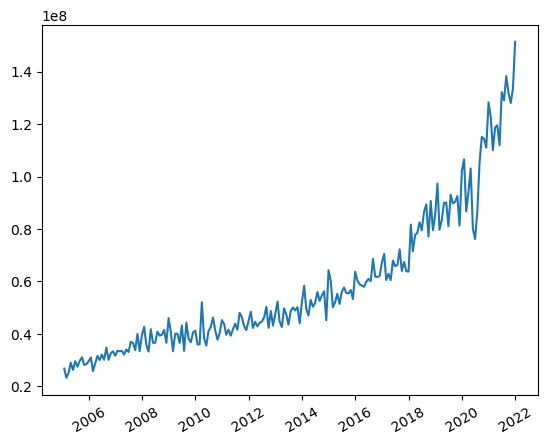

In [50]:
plt.plot(capfl_merged['Total Benefits Authorized'])
plt.xticks(rotation = 30)
plt.show()

In [51]:
rollingseries = capfl_merged['Total Benefits Authorized'].rolling(window = 10)

rollingmean = rollingseries.mean()

print(rollingmean.head(10))

date
2005-01-31           NaN
2005-02-28           NaN
2005-03-31           NaN
2005-04-30           NaN
2005-05-31           NaN
2005-06-30           NaN
2005-07-31           NaN
2005-08-31           NaN
2005-09-30           NaN
2005-10-31    27668647.1
Name: Total Benefits Authorized, dtype: float64


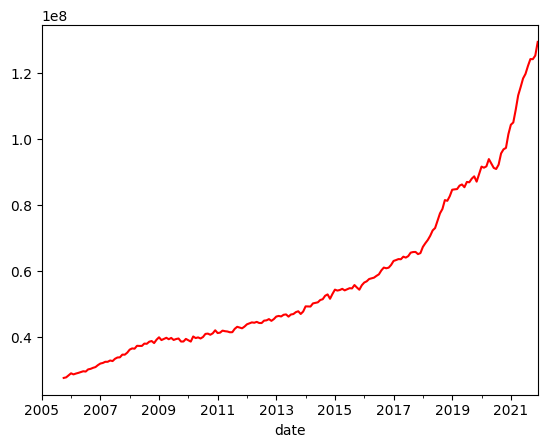

In [52]:
rollingmean.plot(color = 'red')
plt.show()

In [53]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5
import warnings
warnings.filterwarnings('ignore')

data = capfl_merged['Total Benefits Authorized']

fit1 = SimpleExpSmoothing(data).fit(smoothing_level = 0.2, optimized = False)

fit2 = SimpleExpSmoothing(data).fit(smoothing_level = 0.8, optimized = False)

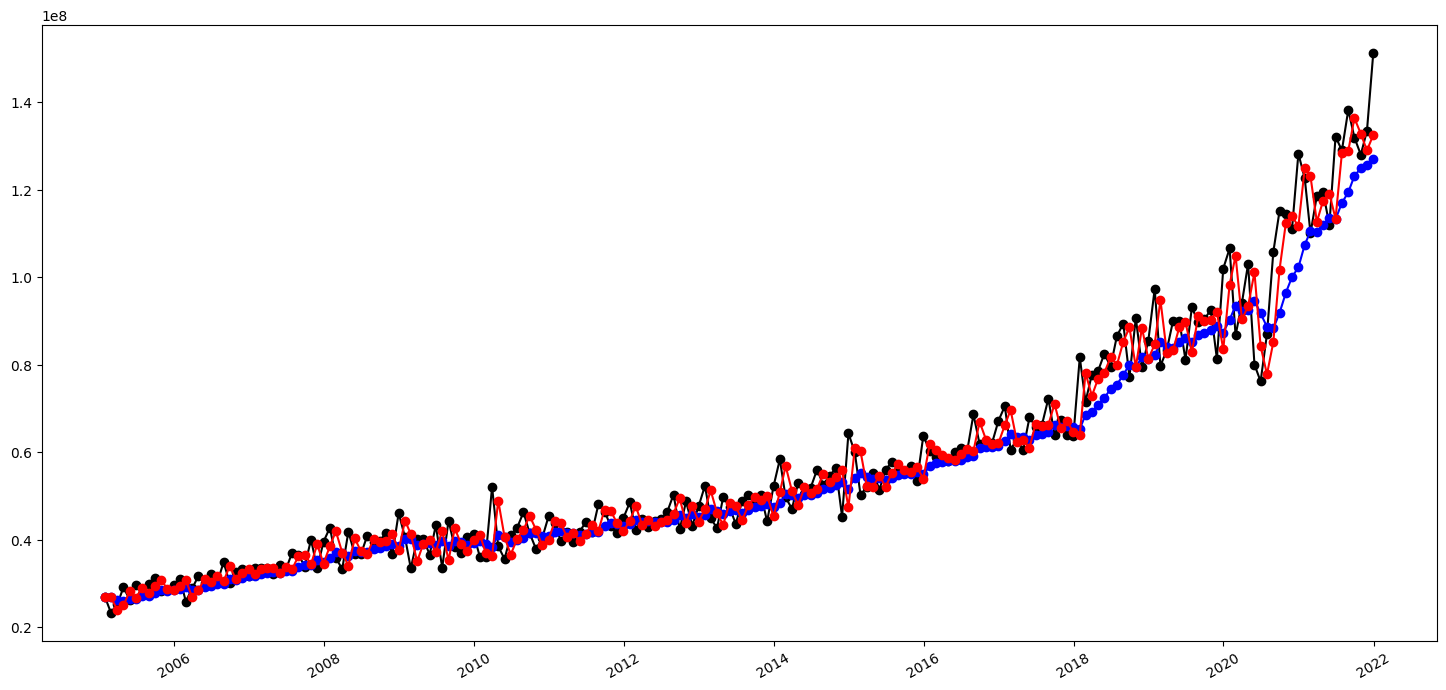

In [54]:
plt.figure(figsize = (18,8))
plt.plot(capfl_merged['Total Benefits Authorized'], marker = 'o', color = 'black')
plt.xticks(rotation = 30)

plt.plot(fit1.fittedvalues, marker = 'o', color = 'blue') # 0.2

plt.plot(fit2.fittedvalues, marker = 'o', color = 'red') # 0.8 (closer to original)

In [55]:
from statsmodels.tsa.stattools import adfuller
adfuller_result = adfuller(capfl_merged['Total Benefits Authorized'].values, autolag='AIC')

print(f'ADF Statistic: {adfuller_result[0]}')

print(f'p-value: {adfuller_result[1]}')

for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 3.6146643588140277
p-value: 1.0
Critial Values:
   1%, -3.4652439354133255
Critial Values:
   5%, -2.8768752281673717
Critial Values:
   10%, -2.574944653739612


Text(0.5, 0.98, '\nMultiplicative Decompose')

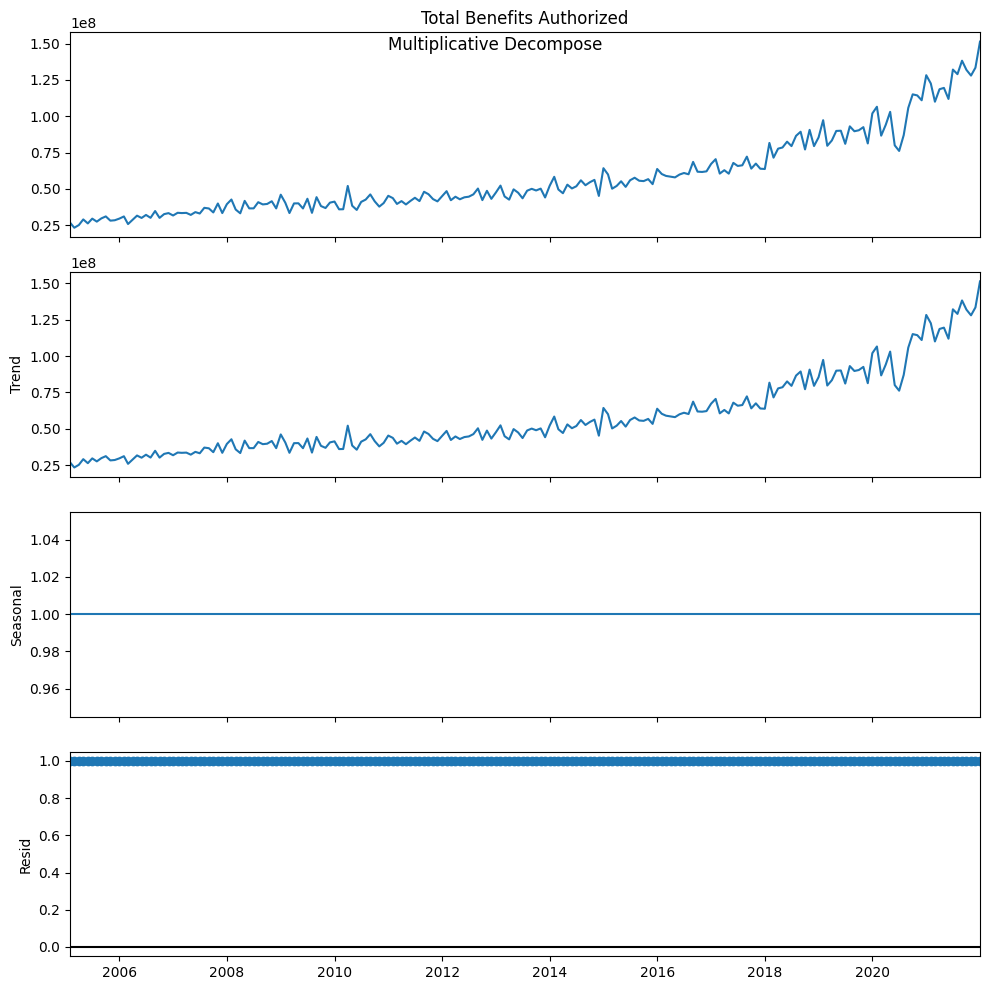

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Multiplicative Decomposition 
mul_result = seasonal_decompose(capfl_merged['Total Benefits Authorized'], model='multiplicative',period=1)

# Additive Decomposition
add_result = seasonal_decompose(capfl_merged['Total Benefits Authorized'], model='additive',period=1)

plt.rcParams.update({'figure.figsize': (10,10)})
mul_result.plot().suptitle('\nMultiplicative Decompose', fontsize=12)

In [57]:
new_df_mult = pd.concat([mul_result.seasonal, mul_result.trend, mul_result.resid, mul_result.observed], axis=1)
new_df_mult.columns = ['seasonality', 'trend', 'residual', 'actual_values']
new_df_mult.head(5)

,seasonality,trend,residual,actual_values
date,,,,
2005-01-31,1.0,26764715.0,1.0,26764715.0
2005-02-28,1.0,23310658.0,1.0,23310658.0
2005-03-31,1.0,25147702.0,1.0,25147702.0
2005-04-30,1.0,29036867.0,1.0,29036867.0
2005-05-31,1.0,26284761.0,1.0,26284761.0


In [58]:
capfl_merged.columns

Index(['Area Type', 'Area Name', 'old_date', 'Month', 'Year',
       'Total PFL First Claims Filled', 'Bonding Claims Filed',
       'Care Claims Filed', 'Total PFL First Claims Paid',
       'Bonding Claims Paid', 'Care Claims Paid',
       'PFL Average Weekly Benefit Amount (AWBA)', 'Weeks Compensated',
       'Average Duration', 'Total Benefits Authorized',
       'Total Benefits Authorized Logged', 'median_income',
       'median_income_logged', 'median_income_weekly',
       'median_income_weekly_logged', 'median_55%', 'max_amt',
       'max_amt_change', 'max_num_weeks', 'geography_type', 'strata',
       'strata_name', 'num_births'],
      dtype='object')

### Data Wrangling Process

#### Picking a topic
- Fourth time's the charm!
    1. FMLA 2018 survey
    1. Legos
    1. Broadband vs. mobile internet
    1. **Paid Family Leave** 🫶

### Data Wrangling Process
#### Learnings from wrangling data:
- dtypes are very important!
- To standardize or log or sum or average... that is the question
- Try other tools to get a sense of the data (e.g. Tableau, Excel, etc.)
- When in doubt, plot it out
- If at first you don't succeed...
    - ask Google | ChatGPT | your cohort | a T.A | Umberto
    - take a break
    - change your data set
    
and then jump for joy when you find something!


### Notes About the Data:

The available datasets are relatively small
- State government makeup: 1992 - 2023 
    - 51 records 
    - 1600 records; then grouped by states and duration
 
- CA PFL was only passed in 2002
- CA PFL calendar year data begins in 2005 and ends in 2022
    - 217 records for CA; 17 when grouped by year

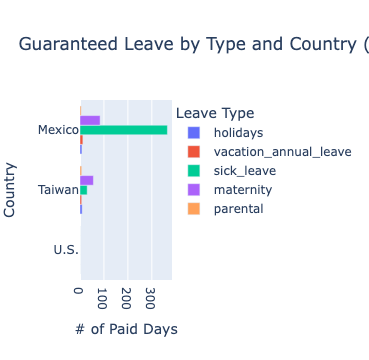

In [73]:
data = {
    'country': ['U.S.', 'Taiwan', 'Mexico'],
    'holidays': [0, 9, 8],
    'vacation_annual_leave': [0, 7, 12],
    'sick_leave': [0, 30, 365],
    'maternity': [0, 56, 84],
    'parental': [0, 7, 5]
}

df = pd.DataFrame(data)

df_melted = pd.melt(df, id_vars=['country'], var_name='Leave Type', value_name='Amount')

fig = px.bar(df_melted, y='country', x='Amount', color='Leave Type',
             title='Guaranteed Leave by Type and Country (on a National/Federal Level)',
             labels={'Amount': 'Leave Amount', 'Leave Type': 'Leave Type'},
             barmode='group')  # Set barmode to 'group'


# Customize the layout
fig.update_layout(
    yaxis_title="Country",
    xaxis_title="# of Paid Days",
)

# Show the plot
fig.show()



### Quiz Time!

How many states have Paid Family Leave programs in effect or pending in the US?


### Answer

**Answer: 15 + D.C.**

California | Colorado | Connecticut | D.C. | Delaware | Illinois | Maine | Maryland | Massachussets | New Hampshire | New Jersey | New York | Oregon | Rhode Island | Vermont | Washington
<div style="text-align:center">
    <img src="PFL_by_State.png" alt="Image Description" style="display: inline-block; height: 600px; width: 800px;">
</div>

  
   

### Political Party Makeup

#### A Tale of Five Models:

|Model|Report|Rating|
|:-----|:------|:------|
Linear Regression and Linear Prediction|Good interpretability; Ok predictions|😐
Logistic Regression - Scikit Learn|Ok Interpretability; Ok predictions|🫤
Logistic Regression - Stats Models|Data explosions|🤯
Decision Tree Classifier|Good interpretability; Simple predictions|🌲
Survival Analysis|Wildcard: Slightly different use case|🫣

In [112]:
print('Linear Regression 😐')

# 0 = Republican
# 1 = Democrat

# 'has_leave' = indicates whether a state has a PFL program:
# does not exist = 0
# exists = 1

modlin = ols('has_leave ~ assembly * senate * governor'
             , data = states).fit()

modlin.summary()

Linear Regression 😐


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              has_leave   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     8.835
Date:                Thu, 07 Sep 2023   Prob (F-statistic):           2.47e-06
Time:                        21:20:35   Log-Likelihood:                -13.044
No. Observations:                  51   AIC:                             40.09
Df Residuals:                      44   BIC:                             53.61
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0435      0.070      0.620      0.539      -0.098       0.185
assembly                     0.6548      0.246      2.659      0.011       0.158       1.151
senate                      -0.0435      0.344     -0.127      0.900      -0.736       0.649
assembly:senate             -0.1548      0.246     -0.628      0.533      -0.651       0.342
governor                    -0.0435      0.154     -0.282      0.779      -0.354       0.267
assembly:governor            0.0119      0.246      0.048      0.962      -0.484       0.508
senate:governor              1.0435      0.440      2.372      0.022       0.157       1.930
assembly:senate:governor    -0.7976      0.305     -2.616      0.012      -1.412      -0.183
==============================================================================
Omnibus:                        6.309   Durbin-Watson:                   0.932
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                7.391
Skew:                          -0.368   Prob(JB):                       0.0248
Kurtosis:                       4.713   Cond. No.                     1.77e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.32e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Political Party Makeup

### 

Intercept = Republican

<div style="text-align:center">
    <img src="linear.png" alt="Image Description" style="display: inline-block; width: 800px; height: 400px;">
</div>

### Linear Predictions 😐
<br></br>
<div align="left">
    
|Assembly|Senate|Governor|Likelihood to Have Paid Family Leave Law|
|--------|------|--------|------------------------|
|D|D|D|71.4%|
|D|D|R|50.0%|
|D|R|R|69.8%|
|D|R|D|66.6%|
|R|D|R| -3.38618 × 10<sup>-13</sup>%|
|R|D|D|100%
|R|R|D|2.44943 × 10<sup>-13</sup>%|
|R|R|R|4.3%|

### Political Party Makeup

#### Linear Regression

When the following are Democratic,
there is a statistically significant greater likelihood of having Paid Family Leave law:
- Assembly: 65.4%
- Senate & Governor: 100.4%

When the following is Democratic,
there is a statistically significant lesser likelihood of having Paid Family Leave law:
- Assembly * Senate * Governor: -79%

In [75]:
#modlin.predict(states[['assembly', 'senate', 'governor']].loc[1])
#type(states[['assembly', 'senate', 'governor']].loc[1])
mypoint = pd.Series({
    'assembly': 0,
    'senate': 0,
    'governor': 1
})
modlin.predict(mypoint)

0    2.615963e-15
dtype: float64

In [76]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Your code that might produce warnings
# ...

# Restore warnings (optional)
warnings.resetwarnings()

y = states['has_leave']
X = states[['assembly', 'senate', 'governor']]
X['DAssemblyXDSenate'] = states.assembly * states.senate
X['DAssemblyXDGovernor'] = states.assembly * states.governor
X['DSenateXDGovernor'] = states.senate * states.governor
X['DAssemblyXDSenateXDGovernor'] = states.assembly * states.senate * states.governor

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1234)  

classifier = LogisticRegression()  

classifier.fit(X, y)  

y_pred = classifier.predict(X) 

#print('When using a logistic regression in scikit-learn, we see that model makes decent predictions.\n')

#print(confusion_matrix(y, y_pred_logreg), end = '\n\n')

#print(classification_report(y, y_pred_logreg))

mypoint = pd.DataFrame({
    'assembly': [0, 1, 0, 0, 1, 1, 1, 1],
    'senate':   [0, 0, 1, 0, 0, 0, 1, 1],
    'governor': [0, 0, 0, 1, 1, 0, 0, 1]
})
mypoint['DAssemblyXDSenate'] = mypoint.assembly * mypoint.senate
mypoint['DAssemblyXDGovernor'] = mypoint.assembly * mypoint.governor
mypoint['DSenateXDGovernor'] = mypoint.senate * mypoint.governor
mypoint['DAssemblyXDSenateXDGovernor'] = mypoint.assembly * mypoint.senate * mypoint.governor
modlin.predict(mypoint)

y_pred2 = classifier.predict_proba(mypoint)
y_pred2[:,1]

/tmp/ipykernel_130/386221858.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_130/386221858.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_130/386221858.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_130/386

array([0.07955827, 0.16660189, 0.1763917 , 0.14642084, 0.39967177,
       0.16660189, 0.33960893, 0.73452266])

In [77]:
print(confusion_matrix(y, y_pred_logreg), end = '\n\n')

print(classification_report(y, y_pred_logreg))

[[31  4]
 [ 6 10]]

              precision    recall  f1-score   support

           0       0.84      0.89      0.86        35
           1       0.71      0.62      0.67        16

    accuracy                           0.80        51
   macro avg       0.78      0.76      0.76        51
weighted avg       0.80      0.80      0.80        51



### Logistic Regression: Scikit Learn 🫤

|Assembly|Senate|Governor|Likelihood to Have Paid Family Leave Law|
|--------|------|--------|------------------------|
|D|D|D|73.4%|
|D|D|R|33.9%|
|D|R|R|16.6%|
|D|R|D|39.9%|
|R|D|R|17.6%|
|R|D|D|16.6%
|R|R|D|14.6%|
|R|R|R|7.9%|

#### Classification & Confusion Matricies


<div style="text-align:center">
    <img src="conf_class.png" alt="Image Description" style="display: inline-block; width: 1000px; height: 400px;">
</div>

In [78]:
X = states[['assembly', 'senate', 'governor']]
X['DAssemblyXDSenate'] = states.assembly * states.senate
X['DAssemblyXDGovernor'] = states.assembly * states.governor
X['DSenateXDGovernor'] = states.senate * states.governor
X['DAssemblyXDSenateXDGovernor'] = states.assembly * states.senate * states.governor
X = X.values
# np.linalg.inv(X.T @ X)
X.T @ X

/tmp/ipykernel_130/2131847704.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_130/2131847704.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_130/2131847704.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_130/213

array([[19, 16, 17, 16, 17, 14, 14],
       [16, 19, 16, 16, 14, 16, 14],
       [17, 16, 25, 14, 17, 16, 14],
       [16, 16, 14, 16, 14, 14, 14],
       [17, 14, 17, 14, 17, 14, 14],
       [14, 16, 16, 14, 14, 16, 14],
       [14, 14, 14, 14, 14, 14, 14]])

In [79]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Your code that might produce warnings
# ...

# Restore warnings (optional)
warnings.resetwarnings()

import statsmodels.api as sm

y = states['has_leave']
X = states[['assembly', 'senate', 'governor']]
X['DAssemblyXDSenate'] = states.assembly * states.senate
X['DAssemblyXDGovernor'] = states.assembly * states.governor
X['DSenateXDGovernor'] = states.senate * states.governor
#X['DAssemblyXDSenateXDGovernor'] = states.assembly * states.senate * states.governor

# Fit a logistic regression model
logit_model = sm.Logit(y, X)

# Obtain and print the summary of the logistic regression
result = logit_model.fit(method = 'bfgs')
print(result.summary())


         Current function value: 0.565423
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                           Logit Regression Results                           
Dep. Variable:              has_leave   No. Observations:                   51
Model:                          Logit   Df Residuals:                       45
Method:                           MLE   Df Model:                            5
Date:                Thu, 07 Sep 2023   Pseudo R-squ.:                 0.09103
Time:                        20:02:10   Log-Likelihood:                -28.837
converged:                      False   LL-Null:                       -31.725
Covariance Type:            nonrobust   LLR p-value:                    0.3286
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
assembly                5.4345      4.441      1.224      

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning:

pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/tmp/ipykernel_130/2169386408.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_130/2169386408.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

### Logistic Regression: Stats Models Learn 🤯

<img src="logit_sum.png"  width="1000" height="1000">


/tmp/ipykernel_130/3267365154.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_130/3267365154.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_130/3267365154.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



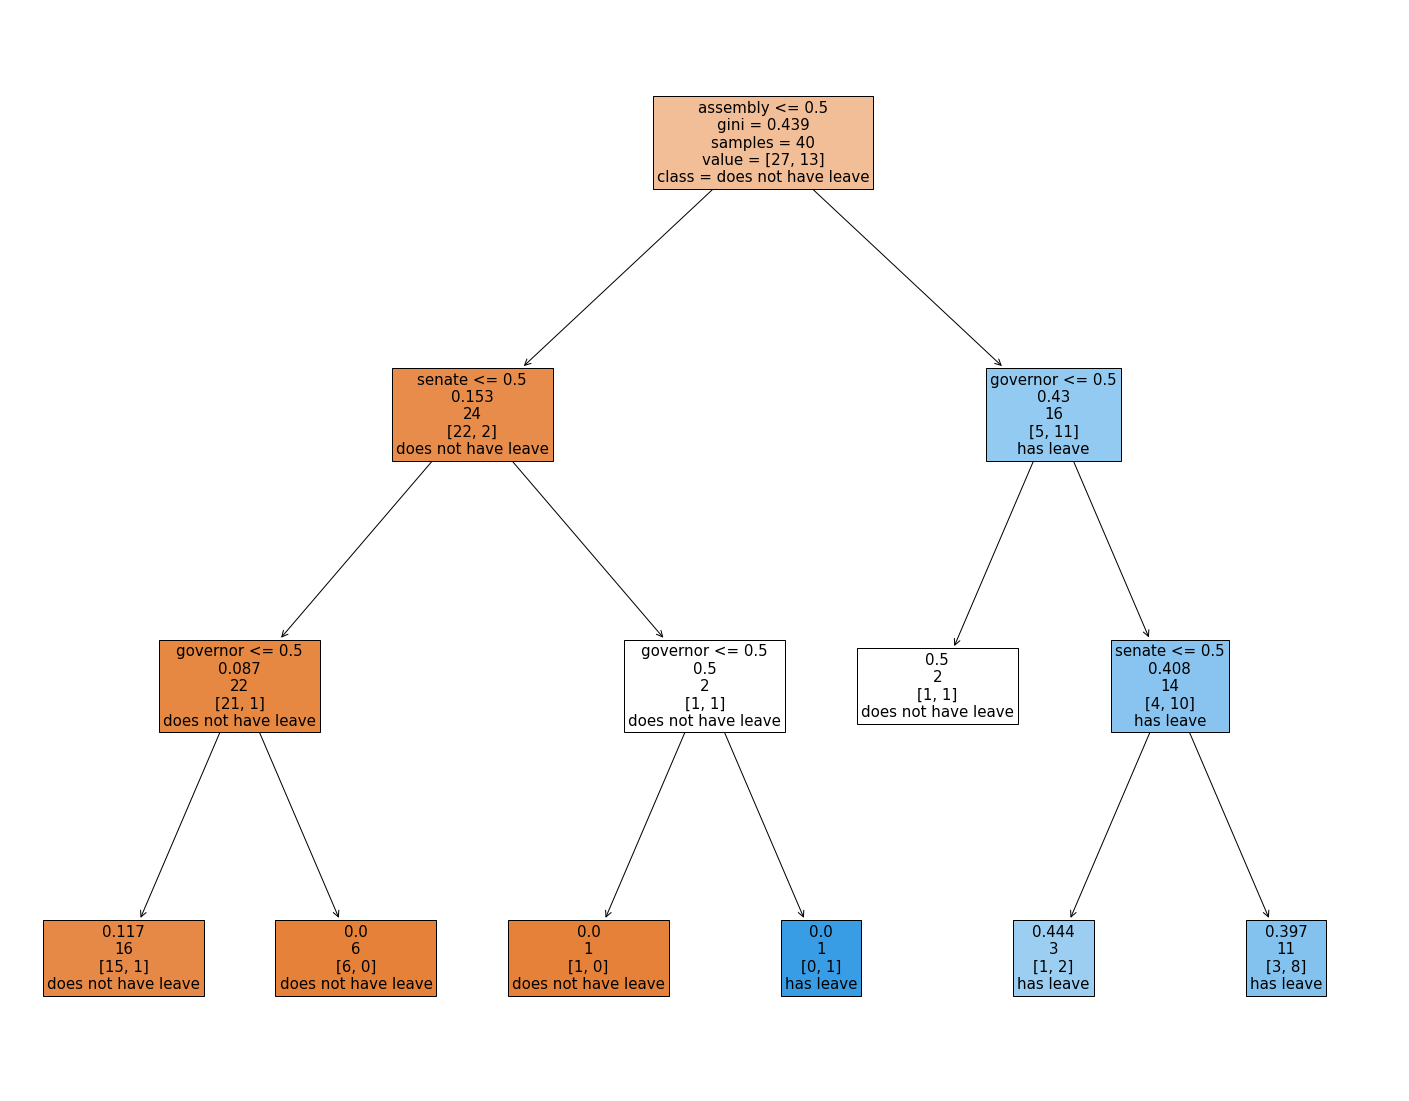

In [80]:
y = states['has_leave']
X = states[['assembly', 'senate', 'governor']]
X['assembly'] = pd.Categorical(X.assembly)
X['senate'] = pd.Categorical(X.senate)
X['governor'] = pd.Categorical(X.governor)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regression_tree = DecisionTreeClassifier(random_state=42)
regression_tree.fit(X_train, y_train)

y_pred = regression_tree.predict(X_test)


fig = plt.figure(figsize = (25,20))
plot_tree(regression_tree, fontsize = 15, feature_names = list(X.columns), 
          max_depth = 3, class_names = ['does not have leave', 'has leave'],
         label = 'root', filled = True)
plt.show()

### Decision Tree 🌲

- If all 3 branches are Democratic, there is 39.7% chance of having a leave law.
- If all 3 branches are Republican, there is an 11.7% chance of having a leave law.

<img src="tree.png"  width="1000" height="1000">

### Survival Analysis 🫣

But what about how *soon* a state will pass a PFL law?

### Survival Analysis 🫣
- Democratic Assemblies tend to pass PFL laws sooner than non-Democratic ones (significant).
- Democratic Senates tend to pass PFL laws a little sooner than non-Democratic ones (almost significant).
- Democratic Governors tend to pass PFL laws at about the same time as non-Democratic ones (not significant).

<img src="surv_sig.png">
<img src="three_3.png">

#### Why Paid Family Leave and not FMLA?
- No centralized reporting of FMLA claims

#### Why California?
- First in the nation to have a paid family leave program
- Most observations for analysis

## Paid Family Leave Insights

### Benefit Usage

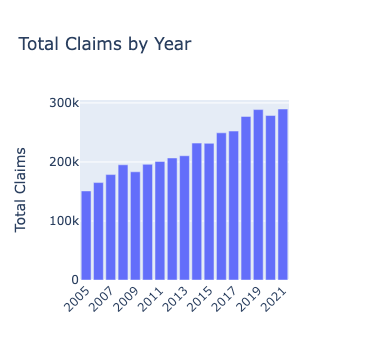

In [81]:
yearly_totals = pfl_comb_y.groupby('year')['total_file_paid_avg'].sum().reset_index()

# Create the bar plot using Plotly Express
fig = px.bar(
    yearly_totals,
    x='year',
    y='total_file_paid_avg',
    title='Total Claims by Year',
    labels={'year': 'Year', 'total_file_paid_avg': 'Total Claims'},
)

# Customize the layout (optional)
fig.update_layout(
    xaxis=dict(type='category'),  # Set x-axis to categorical
    xaxis_title='',  # Set x-axis title
    yaxis_title='Total Claims',  # Set y-axis title
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
)

# Show the plot
fig.show()

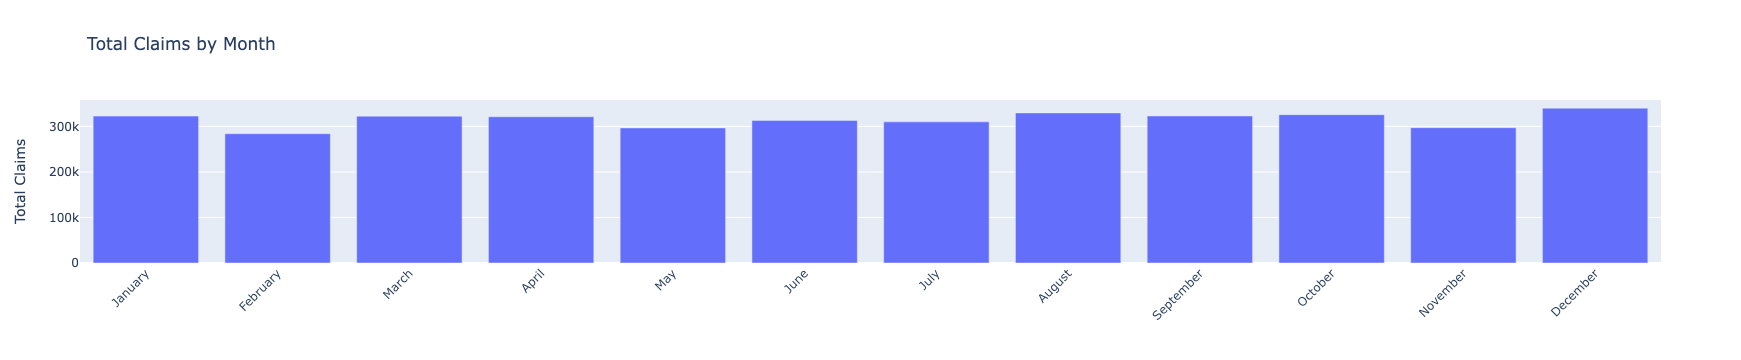

In [82]:
monthly_totals = pfl_comb.groupby('month')['total_file_paid_avg'].sum().reset_index()

colorblind_palette = ['#1f77b4', '#ff7f0e']

fig = px.bar(
    monthly_totals,
    x='month',
    y='total_file_paid_avg',
    title='Total Claims by Month',
    labels={'month': 'Month', 'total_file_paid_avg': 'Total Claims'},
)

fig.update_layout(
    xaxis=dict(type='category'), 
    xaxis_title='',  
    yaxis_title='Total Claims', 
    xaxis_tickangle=-45, 
)

fig.show()

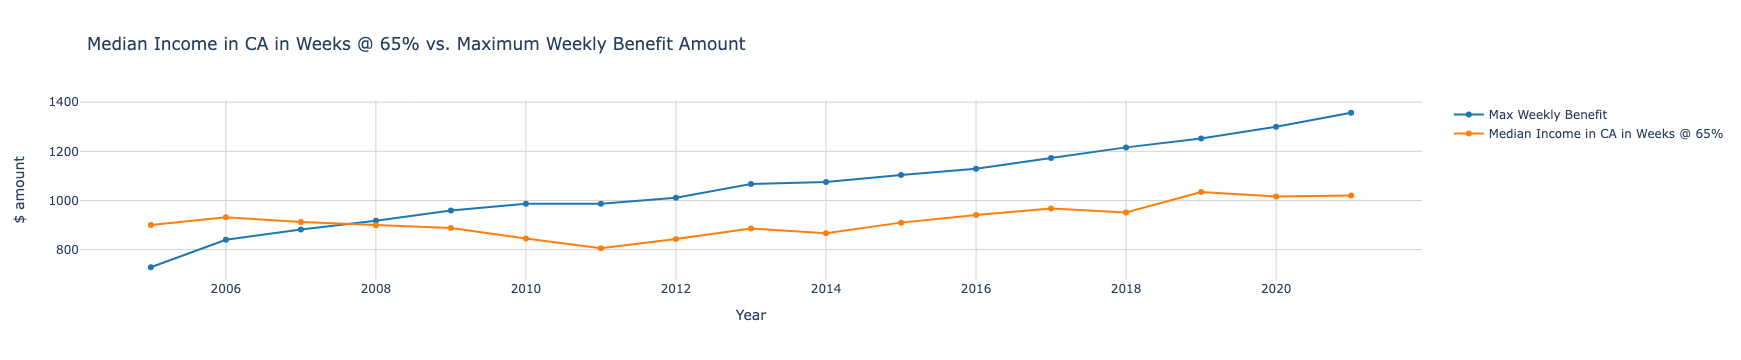

In [83]:
colorblind_palette = ['#1f77b4', '#ff7f0e']

trace1 = go.Scatter(x=pfl_comb_y['year'], 
                    y=pfl_comb_y['mwba_d'], 
                    name = "Max Weekly Benefit",
                   line=dict(color=colorblind_palette[0]))

trace2 = go.Scatter(x=med_inc['year'], 
                    y=med_inc['med_inc_max_wk'], 
                    name="Median Income in CA in Weeks @ 65%", 
                    line=dict(color=colorblind_palette[1]))


fig = go.Figure()
fig.add_trace(trace1)
fig.add_trace(trace2)


layout = go.Layout(
    title='Median Income in CA in Weeks @ 65% vs. Maximum Weekly Benefit Amount',
    plot_bgcolor='white', 
    xaxis=dict(title='Year', showgrid=True, gridcolor='lightgray'),
    yaxis=dict(title='$ amount', showgrid=True, gridcolor='lightgray'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()



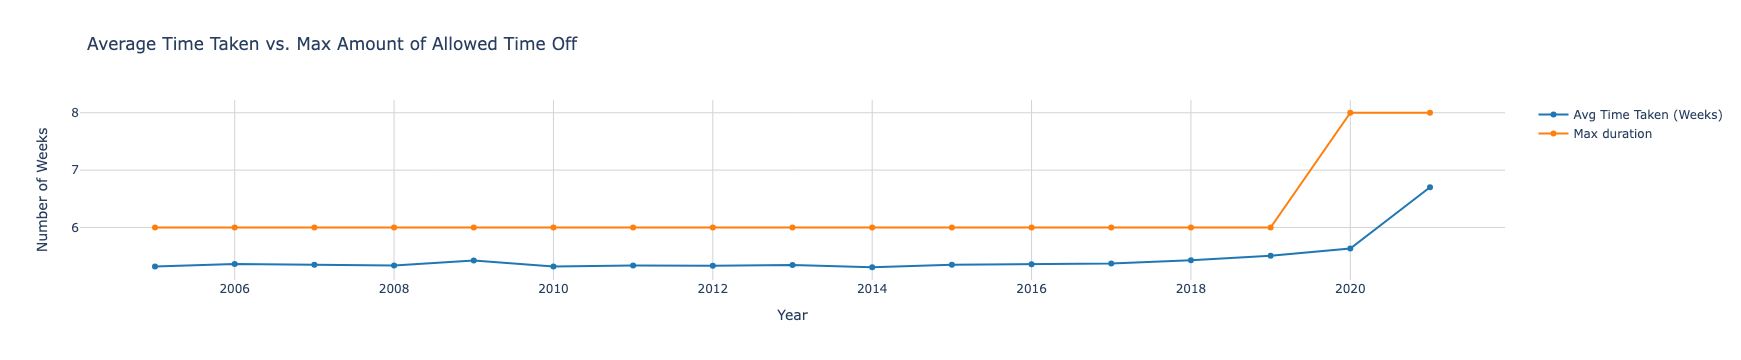

In [84]:
# print('Individuals are taking close to, but not the maximum amount of allowed time off.')
# print('In 2019 leave increased to 8 weeks. In the first 3 years, people took more time, but not the max.')
# print('This shows that claimants take advantage of the benefit.')

colorblind_palette = ['#1f77b4', '#ff7f0e']

trace1 = go.Scatter(x=grouped_avg_duration['year'], y=grouped_avg_duration['avg_duration'], 
                    name = "Avg Time Taken (Weeks)",
                   line=dict(color=colorblind_palette[0]))


trace2 = go.Scatter(x=week_max['year'], y=week_max['week_max_d'], 
                    name = "Max duration",
                   line=dict(color=colorblind_palette[1]))

fig = go.Figure()
fig.add_trace(trace1)
fig.add_trace(trace2)


layout = go.Layout(
    title='Average Time Taken vs. Max Amount of Allowed Time Off',
    plot_bgcolor='white',  # Set the background color to white
    xaxis=dict(title='Year', showgrid=True, gridcolor='lightgray'),
    yaxis=dict(title='Number of Weeks', showgrid=True, gridcolor='lightgray')
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show() 

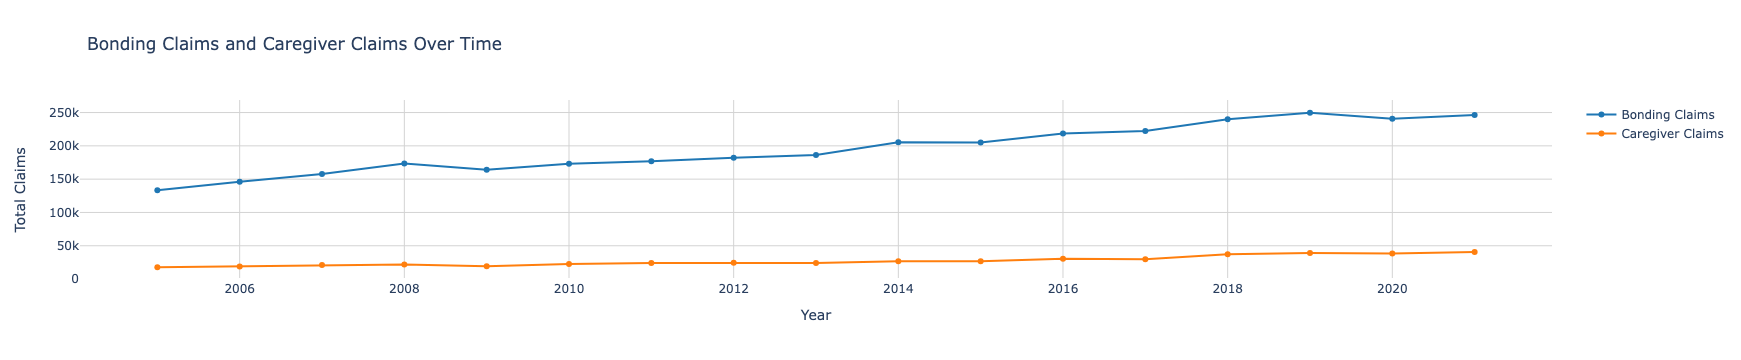

In [85]:
# print('This tells us that more people use the benefit for bonding claims vs. caregiving claims.')

colorblind_palette = ['#1f77b4', '#ff7f0e']

trace1 = go.Scatter(x=grouped_bond_avg['year'], 
                    y=grouped_bond_avg['bond_claims_tot'], 
                    name = "Bonding Claims",
                   line=dict(color=colorblind_palette[0]))

trace2 = go.Scatter(x=grouped_care_avg['year'], 
                    y=grouped_care_avg['care_claims_tot'], 
                    name = "Caregiver Claims",
                   line=dict(color=colorblind_palette[1]))

fig = go.Figure()
fig.add_trace(trace1)
fig.add_trace(trace2)

# fig.update_layout(
#     title="Bonding Claims and Caregiver Claims Over Time",
#     xaxis=dict(title="Year"),
#     yaxis=dict(title="Claims Total"))

layout = go.Layout(
    title='Bonding Claims and Caregiver Claims Over Time',
    plot_bgcolor='white',  # Set the background color to white
    xaxis=dict(title='Year', showgrid=True, gridcolor='lightgray'),
    yaxis=dict(title='Total Claims', showgrid=True, gridcolor='lightgray')
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()  
    


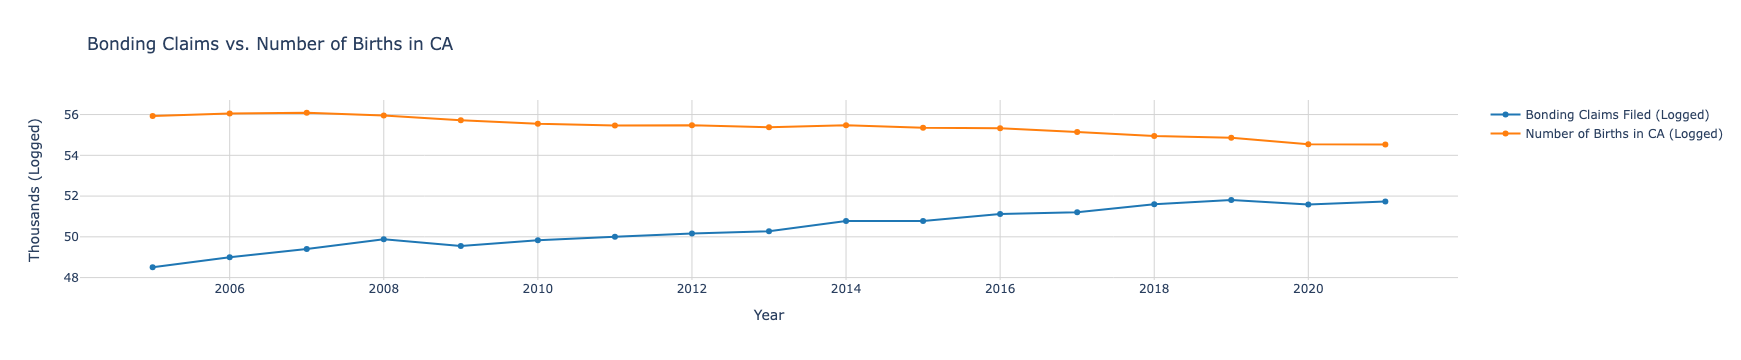

In [86]:
# print('This shows us that while the birth rate in CA is declining, the number of bonding claims are increasing.')
# print('There should be close to a 2:1 ratio of claims to births thus indicating a lower takeup of the benefit overall from the eligibile population.')

colorblind_palette = ['#1f77b4', '#ff7f0e']

trace1 = go.Scatter(x=grouped_bond_log_avg['year'], y=grouped_bond_log_avg['log_bond_claims_tot'], 
                    name = "Bonding Claims Filed (Logged)",
                   line=dict(color=colorblind_palette[0]))
trace2 = go.Scatter(x=grouped_births_log['year'], y=grouped_births_log['log_num_births'], 
                    name = "Number of Births in CA (Logged)",
                   line=dict(color=colorblind_palette[1]))

fig = go.Figure()
fig.add_trace(trace1)
fig.add_trace(trace2)

layout = go.Layout(
    title='Bonding Claims vs. Number of Births in CA',
    plot_bgcolor='white',  # Set the background color to white
    xaxis=dict(title='Year', showgrid=True, gridcolor='lightgray'),
    yaxis=dict(title='Thousands (Logged)', showgrid=True, gridcolor='lightgray')
)

fig = go.Figure(data=[trace1, trace2], layout=layout)


fig.show()

## Paid Family Leave Insights

### Predictors of the Program

Bonding Claims and Births

For each additional birth the number of bonding claims decreases by -0.74 (p = 0.000).


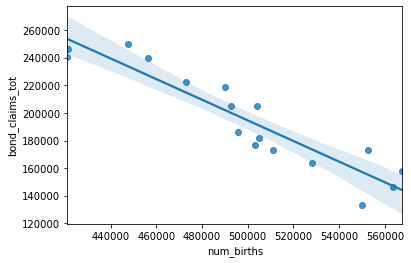

In [92]:
print('Bonding Claims and Births\n')
print('For each additional birth the number of bonding claims decreases by -0.74 (p = 0.000).')

modlin = ols('bond_claims_tot ~ num_births'
             , data = pfl_comb_y).fit()
#modlin.summary()

sns.regplot(x = 'num_births', y = 'bond_claims_tot', data = pfl_comb_y)
plt.show()

Caregiving Claims and Births

For each additional birth the number of bonding claims decreases by -0.15 (p = 0.000).


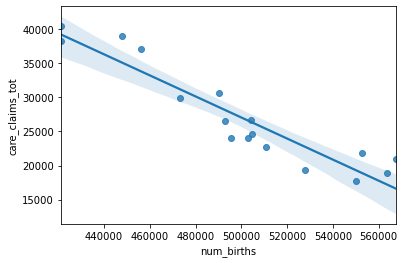

In [95]:
print('Caregiving Claims and Births\n')
print('For each additional birth the number of bonding claims decreases by -0.15 (p = 0.000).')

modlin = ols('care_claims_tot ~ num_births'
             , data = pfl_comb_y).fit()
#modlin.summary()

sns.regplot(x = 'num_births', y = 'care_claims_tot', data = pfl_comb_y)
plt.show()

Bonding Claims and Max Weekly Benefit Amount

For every one dollar increase in the maximum weekly benefit we see an increase of 209 cases on average (p = 0.000).


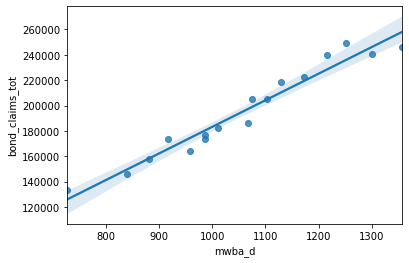

In [96]:
print("Bonding Claims and Max Weekly Benefit Amount\n")
print('For every one dollar increase in the maximum weekly benefit we see an increase of 209 cases on average (p = 0.000).')

modlin = ols('bond_claims_tot ~ mwba_d'
             , data = pfl_comb_y).fit()
#modlin.summary()

sns.regplot(x = 'mwba_d', y = 'bond_claims_tot', data = pfl_comb_y)
plt.show()

Caregiving Claims and Max Weekly Benefit Amount

For every one dollar increase in the maximum weekly benefit we see an increase of 41 cases on average (p = 0.000).


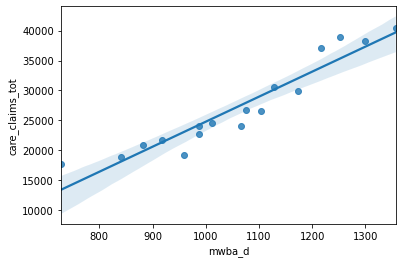

In [97]:
print('Caregiving Claims and Max Weekly Benefit Amount\n')
print('For every one dollar increase in the maximum weekly benefit we see an increase of 41 cases on average (p = 0.000).')

modlin = ols('care_claims_tot ~ mwba_d'
             , data = pfl_comb_y).fit()
#modlin.summary()

sns.regplot(x = 'mwba_d', y = 'care_claims_tot', data = pfl_comb_y)
plt.show()

Bonding claims and Median Household Income

For every one dollar increase in the median household income we see an increase of 4.8 cases on average (p = 0.003).


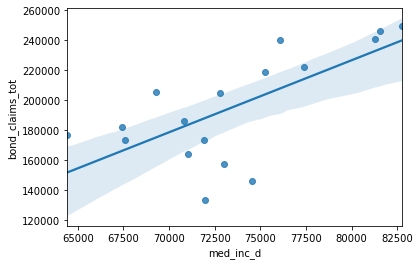

In [102]:
print('Bonding claims and Median Household Income\n')
print('For every one dollar increase in the median household income we see an increase of 4.8 cases on average (p = 0.003).')

modlin = ols('bond_claims_tot ~ med_inc_d'
             , data = pfl_comb_y).fit()
#modlin.summary()

sns.regplot(x = 'med_inc_d', y = 'bond_claims_tot', data = pfl_comb_y)
plt.show()

Caregiving Claims and Median Household Income

For every one dollar increase in the median household income we see an increase of 1.08 cases on average (p = 0.003).


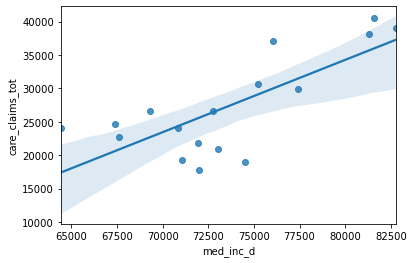

In [103]:
print('Caregiving Claims and Median Household Income\n')
print('For every one dollar increase in the median household income we see an increase of 1.08 cases on average (p = 0.003).')

modlin = ols('care_claims_tot ~ med_inc_d'
             , data = pfl_comb_y).fit()
#modlin.summary()

sns.regplot(x = 'med_inc_d', y = 'care_claims_tot', data = pfl_comb_y)
plt.show()

## Paid Family Leave Takeaways

This leads us to believe that the following impact whether individuals take time off to bond with a new child or caregive for a family member:

- Median household income
- Maximum weekly benefit amount
- Births in CA

And while not all individuals take advantage of their benefits, those who do tend to take the full time.


## Future Considerations:

- Influence of other progressive laws
- Quality of PFL programs
- Incorporating demographic data
- Other states' paid leave laws

## Project Graveyard: Legos

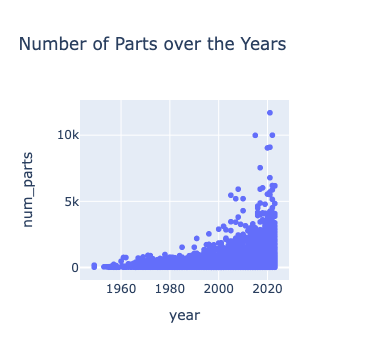

In [91]:
lt_o = pd.read_csv('themes_aug2023.csv')
ls_o = pd.read_csv('sets_aug2023.csv')

lt = lt_o.copy(deep=True)
ls = ls_o.copy(deep=True)

ls_high = ls[(ls['num_parts'] >= 20)]
ls_high.sort_values(by = 'num_parts', ascending = False)

fig = px.scatter(
    data_frame = ls_high,
    x = "year", 
    y = "num_parts",
    title = "Number of Parts over the Years",
    hover_data = ['name','num_parts'],
)

fig.show()